In [22]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
from matplotlib import pyplot as plt
from collections import namedtuple
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

____________
### Задача 1

Предположим, что вы разработали лекарство от коронавируса. Перед применением оно обязательно должно пройти клинические испытания. Для начала было разрешено проверить лекарство на двух независимых группах по 10 человек. Одна группа принимает плацебо, другая -- ваш препарат. Большее количество пациентов на первом этапе брать не разрешают -- слишком велики риски отрицательного результата.

Для каждого пациента измерялось количество дней от приема препарата до выздоровления. Получились следуюшие результаты:

In [5]:
placebo = [6, 16, 8, 13, 9, 4, 7, 10, 3, 14]
medicine = [5, 10, 3, 1, 5, 3, 19, 2, 2, 5]

Что вы можете сказать на основе этих результатов?
* Лекарство эффективнее, подтверждается статистическими методами;
* Наверное, лекарство эффективнее, но статистическими методами это пока не подтверждено, нужно продолжить эксперимент. Подумайте, как обосновать необходимость продолжение эксперимента;
* По результатам эксперимента нельзя сделать какой-либо вывод. Стоит ли продолжать эксперименты? Если да, то четко это обоснуйте;
* Лекарство неэффективно, нужно немедленно прекращать эксперимент.

Естественно, для того, чтобы сделать выводы по этой задаче, требуется воспользоваться критериями дисперсионного анализа для сравнения средних.

Поскольку люди были разные, можем пользоваться методами для независимых выборок.

**t-test**

Самый простой **<font color="red">возможный</font>** способ - это критерий Стьюдента для независимых выборок

In [6]:
sps.ttest_ind(placebo, medicine, equal_var=False)

Ttest_indResult(statistic=1.6077916961893066, pvalue=0.12612583305411368)

В данном случае нет отвержения. При этом этот критерий требует нормальности выборок, которой может здесь не быть, либо же большой выборки

**Критерий Уилкоксона-Манна-Уитни**

Ещё один **<font color="red">возможный</font>** способ проверки - критерий Манна-Уитни. Применим его

In [7]:
sps.mannwhitneyu(placebo, medicine, alternative='greater')

MannwhitneyuResult(statistic=76.5, pvalue=0.024256557087931816)

Тогда гипотеза равенства средних отвергается на уровне значимости $0.05$, однако надо быть внимательным.

В данном случае размер выборки всего $10$, а асимптотика в критерии Манна-Уитни без использования поправок справедлива лишь тогда, когда размер обеих выборок не меньше $50$

**Перестановочный критерий**

Оставшийся вариант - разобранные на лекции перестановочные критерии. Если даны две выборки $X$ и $Y$, то в качестве статистики можно взять $\overline{X} - \overline{Y}$.

В качестве группы перестановок:

$$G = \{(s_1, \dots, s_{n+m})\ |\ \{s_1, \dots, s_n\} \in \mathcal{C}_{\{1, \dots, n+m\}}^n\}$$

Посчитаем статистику для всех перестановок отсюда

In [8]:
N_SAMPLES = int(1e5) # количество бутстрепных перестановок

In [9]:
n = len(placebo)
m = len(medicine)
concated = np.array(placebo + medicine)

bootstrap_stats = []

for _ in tqdm(range(N_SAMPLES)):
    # выбираем индексы для первой части
    index_x = np.random.choice(np.arange(n + m), n, replace=False)
    # выделяем оставшиеся
    index_y = np.arange(n + m)[~np.in1d(np.arange(n + m), index_x)]
    
    x_iter = concated[index_x]
    y_iter = concated[index_y]
    
    # добавляем статистику от перестановки
    bootstrap_stats.append(np.mean(x_iter) - np.mean(y_iter))

Смотрим, в какой доле случаев статистика после перестановки оказывается больше изначальной (случай для односторонней альтернативы)

In [10]:
(np.array(bootstrap_stats) > (np.mean(placebo) - np.mean(medicine))).mean()

0.05657

Получаем, что снова нет отвержения.

Однако это не единственная статистика, которую можно использовать. Например, можно взять статистику Манна-Уитни. Это сумма рангов срока выздоровления при приёме лекарства, то есть, если лекарство имеет эффект, то выздоровление происходит скорее, и статистика будет меньше, чем в противном случае. Так что знак в проверке стоит развернуть.

Проведём такую же процедуру для статистики Манна-Уитни.

In [11]:
n = len(placebo)
m = len(medicine)
concated = np.array(placebo + medicine)

bootstrap_stats = []

for _ in tqdm(range(N_SAMPLES)):
    # выбираем индексы для первой части
    index_x = np.random.choice(np.arange(n + m), n, replace=False)
    # выделяем оставшиеся
    index_y = np.arange(n + m)[~np.in1d(np.arange(n + m), index_x)]
    
    x_iter = concated[index_x]
    y_iter = concated[index_y]
    
    # считаем статистику Манна-Уитни
    bootstrap_stats.append(sps.mannwhitneyu(x_iter, y_iter)[0])

In [12]:
(np.array(bootstrap_stats) < sps.mannwhitneyu(placebo, medicine)[0]).mean()

0.04015

**Вывод:**

В критерии перестановок с использованием статистики Манна-Уитни наблюдается отвержение на уровне значимости $0.05$. Ясно, что такой критерий не первым приходит в голову, но всё-таки даже на такой небольшой выборке можно найти корректную процедуру, которая подтвердит статистическую значимость. Но тем не менее можно сказать, что это отвержение "на грани", поэтому, если есть возможность, то стоит ещё поэкпериментировать.

**AA-тест**

Проверим, как подобная процедура будет работать, если нулевая гипотеза верна. Запустим её на двух выборках из одинакового равномерного распределения.

Посмотрим на распределение pvalue. Оно должно получиться равномерным. Для этого проведём AA-тест много раз

In [ ]:
def make_aa_test(sample_size, n_samples):
    """
    Функция проведения AA-теста
    Применяет перестановочный критерий со статистикой Манна-Уитни
    к выборкам из U[0, 20] одинакового размера
    
    Параметры
    ----------
    sample_size : int
        Размер каждой выборки
    n_samples : int
        Количество бутстрепных перестановок
    Возвращает
    -------
    float : pvalue
    """
    
    distr = sps.randint(low=1, high=20)
    x = distr.rvs(sample_size)
    y = distr.rvs(sample_size)
    concated = np.hstack([x, y])
    
    bootstrap_stats = []
    for _ in range(n_samples):
        index_x = np.random.choice(np.arange(n + m), n, replace=False)
        index_y = np.arange(n + m)[~np.in1d(np.arange(n + m), index_x)]

        x_iter = concated[index_x]
        y_iter = concated[index_y]

        bootstrap_stats.append(sps.mannwhitneyu(x_iter, y_iter)[0])
        
    return (np.array(bootstrap_stats) < sps.mannwhitneyu(x, y)[0]).mean()

Проведём тест один раз

In [19]:
make_aa_test(sample_size=len(medicine), n_samples=N_SAMPLES)

0.6458

Видно, что нет отвержения на одинаковых распределениях. Но с некоторой вероятностью могло произойти и отвержение. Посмотрим на распределение pvalue.

In [20]:
N_TESTS = 500 # количество AA-тестов

pvalues = []
for _ in tqdm(range(N_TESTS)):
    pvalues.append(make_aa_test(sample_size=len(medicine), n_samples=10000))

Построим гистограмму

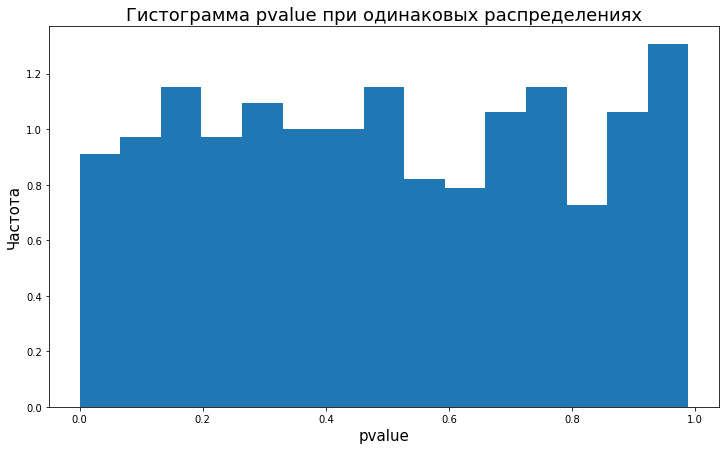

In [26]:
plt.figure(figsize=(12, 7))
plt.title('Гистограмма pvalue при одинаковых распределениях', fontsize=18)
plt.xlabel('pvalue', fontsize=15)
plt.ylabel('Частота', fontsize = 15)
plt.hist(pvalues, density=True, bins=15)
plt.show()

In [27]:
pvalues = np.array(pvalues)
n_rejects = np.sum(pvalues < 0.05)
print('Доля отвержений: {:.3f}'.format(n_rejects / pvalues.size))

Доля отвержений: 0.052


**Вывод:**

По гистограмме видим, что распределение похоже на равномерное. Возможно, будет ещё больше похоже при увеличении количества запусков АА-теста. Доля отвержений близка к $0.05$, но для точной оценки нужно гораздо больше запусков. 

_____
### Задача 2

В задании 6 по машинному обучению вы предсказывали цену жилья по его характеристикам, в процессе чего принимали участие на Kaggle. Пришло время внедрять разработки в продакшн. На первый взгляд может показаться, что внедрять нужно решение победителя, однако оно может повлечь множество технических сложностей при работе в продакшне, поэтому предлагается выбрать оптимум между качеством и технической сложностью модели. В данной задаче вам предлагается исследовать модели на наличие статистически значимой разницы по их качеству. Не забывайте про практическую значимость результата.

Сравните три модели по качеству предсказания на тестовой выборке: свою и два решения, рассказанных на семинарах. В решении данного задания не нужно приводить код каждой из моделей. Достаточно прочитать 4 файла: истинные ответы на тесте и предсказания трех моделей.
_____

Сравнивать модели будем по значениям функции ошибки, которые получаются у этих моделей на тестовой выборке. В данном соревновании стояла задача регрессии, поэтому можно оценивать модели по MAPE, то есть по средней относительной ошибке в процентах.

Таким образом, если есть правильные ответы $Y_i$ и предсказания модели $\widehat{Y}_i$, то можно получить выборку ошибок:

$$e_i = \frac{\left|Y_i - \widehat{Y}_i\right|}{Y_i}$$

Тогда, если у двух моделей получились ошибки $e^1$ и $e^2$, то нас интересует гипотеза о равенстве средних.

Модели были обучены на одной выборке, они получают один и тот же вход, значит эти выборки зависимы. Поэтому будем пользоваться критерием знаков.

Можем считать, что в данных есть шум, который не убирается моделью, и его распределение одинаково для двух моделей, потому что данные те же. А значит предположения критерия знаков выполнены.

Для начала загрузим данные: правильные ответы, а также ответы двух лучших работ и бейзлайна

In [2]:
golden_answers = pd.read_csv('solution.csv', 
                             index_col='index')
ivanov_answers = pd.read_csv('answer_Viacheslav_Ivanov.csv', 
                             index_col='index')
gracheva_answers = pd.read_csv('answer_Anastasia_Gracheva.csv', 
                               index_col='index')
baseline_ansers = pd.read_csv('sample_submission.csv', 
                              index_col='index')

In [3]:
golden_answers.head()

,price
index,
1,330000
2,960000
3,219900
4,430000
5,221700


Вычислим выборки ошибок. Поменяв функцию вычисления, можно перейти к другим ошибкам, например, MSE или MAE

In [4]:
def get_errors(answers_df):
    """Функция подсчёта ошибок"""
    
    correct = golden_answers.values
    predicted = answers_df.values
    return (np.abs(correct - predicted) * 100. / correct) \
            .reshape(answers_df.values.size)

In [5]:
ivanov_errors = [] # Слава не ошибается

In [6]:
ivanov_errors = get_errors(ivanov_answers)
gracheva_errors = get_errors(gracheva_answers)
baseline_errors = get_errors(baseline_ansers)

Теперь необходимо проверить $3$ гипотезы о равенстве средних в этих ошибках. Для проверки напишем функцию, которая вычислит pvalue для критерия знаков, а также построит сравнительный график kde распределений ошибок

In [7]:
# Переиспользуем код из прошлого задания
SignedTestResult = namedtuple('SignedTestResult', ('statistic', 'pvalue'))

def _signedtest_n_greater_15(s, n, alternative):
    """Внутренняя функция, считает критерий знаков для случая n > 15"""
    
    assert n > 15
    
    statistics = (s - n / 2 - 1 / 2) / np.sqrt(n / 4)
    
    if alternative == 'two-sided':
        pvalue = 2 * min(sps.norm.sf(statistics), sps.norm.cdf(statistics))
    elif alternative == 'less':
        pvalue = sps.norm.cdf(statistics)
    else:
        pvalue = sps.norm.sf(statistics)

    return SignedTestResult(statistics, min(pvalue, 1))

def _signedtest_n_small_sizes(s, n, alternative):
    """Внутренняя функция, считает критерий знаков для случая n <= 15"""
    
    assert n <= 15
    
    statistics = s
    left_part = sps.binom.cdf(statistics, n, 1/2)
    right_part = sps.binom.sf(statistics, n, 1/2)

    if alternative == 'two-sided':
        pvalue = 2 * min(left_part, right_part)
    elif alternative == 'less':
        pvalue = left_part
    else:
        pvalue = right_part
        
    return SignedTestResult(statistics, min(pvalue, 1))

def signedtest(differences, alternative='two-sided'):
    """
    Критерий знаков
    Параметры
    ----------
    differences : array_like
        Массив разностей между двумя связными выборками
    alternative : {'two-sided', 'less', 'greater'}, optional
        Определение альтернативной гипотезы. 
        'two-sided' - альтернативная гипотеза: медиана ошибок не равна 0
        'less' - альтернативная гипотеза: медиана ошибок меньше 0
        'greater' - альтернативная гипотеза: медиана ошибок больше 0
    Возвращает
    -------
    statistic : float
    pvalue : float
    """
    
    assert alternative in ['two-sided', 'less', 'greater']
    
    z = differences
    z = np.unique(np.array(z))  # выкидываем совпадения
    s = np.sum(z > 0)
    n = z.shape[0]
    
    if n > 15:
        return _signedtest_n_greater_15(s, n, alternative)
    return _signedtest_n_small_sizes(s, n, alternative)

In [8]:
def make_models_comparison(x_errs, y_errs, label_x='First', 
                           label_y='Second', max_err=100):
    """
    Функция для сравнения моделей регрессии в соревновании
    Печатает pvalue, абсолютную и относительную разницу в метриках
    Строит график распределений ошибок
    
    Параметры
    ----------
    x_errs : array_like, 1d
        Ошибки первой модели
    y_errs : array_like, 1d
        Ошибки второй модели
    label_x : str
        Название первой модели
    label_y : str
        Название второй модели
    max_err : float
        Наибольшая ошибка, правый предел графика
    Возвращает
    -------
    float : pvalue
    """
    
    plt.figure(figsize=(12, 7))
    plt.title('Распределения ошибок', fontsize=20)
    plt.xlabel('Значение ошибки', fontsize=15)
    plt.ylabel('Плотность', fontsize=15)
    sns.kdeplot(x_errs, shade=True, label=label_x, gridsize=5000)
    sns.kdeplot(y_errs, shade=True, label=label_y, gridsize=5000)
    plt.xlim((0, max_err))
    plt.legend(fontsize=15)
    plt.show()
    
    diff = x_errs.mean() - y_errs.mean()
    diff_percent = diff / x_errs.mean()
    
    _, pvalue = signedtest(x_errs - y_errs)
    print('p-value критерия знаков: {:.5f}'.format(pvalue))
    print('Разница средних: {:.3f}'.format(diff))
    print('Относительная разница: {:.1%}'.format(diff_percent))
    return pvalue

Теперь применим критерий 3 раза, потом применим процедуру МПГ при помощи метода Холма

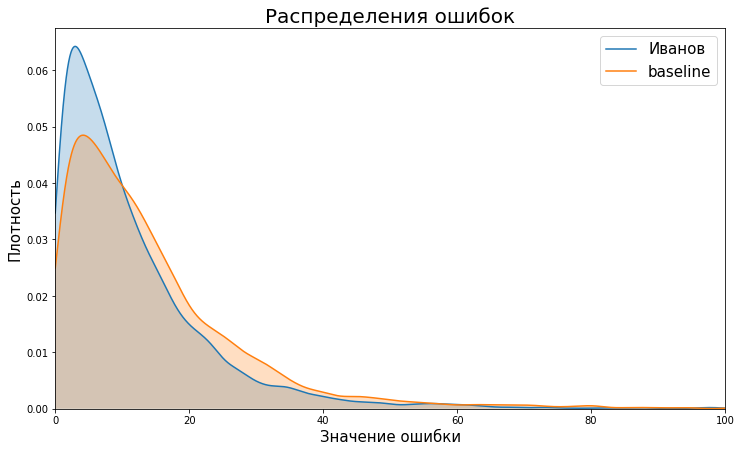

p-value критерия знаков: 0.00000
Разница средних: -3.019
Относительная разница: -26.0%


In [9]:
ivanov_base = make_models_comparison(
    ivanov_errors,
    baseline_errors,
    label_x='Иванов',
    label_y='baseline'
)

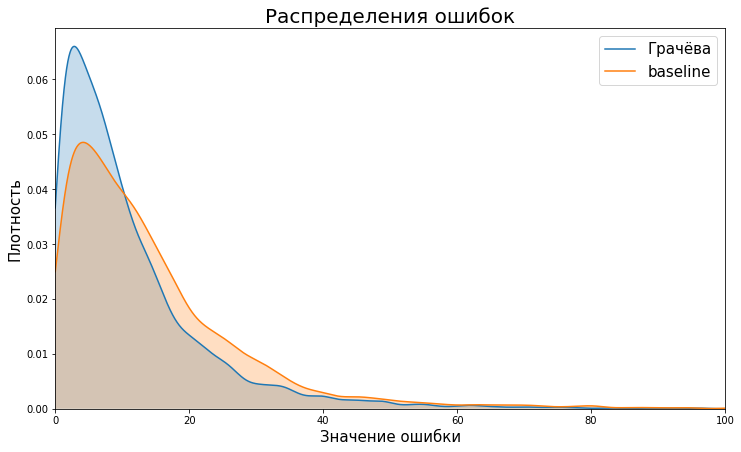

p-value критерия знаков: 0.00000
Разница средних: -3.353
Относительная разница: -29.7%


In [10]:
gracheva_base = make_models_comparison(
    gracheva_errors,
    baseline_errors,
    label_x='Грачёва',
    label_y='baseline'
)

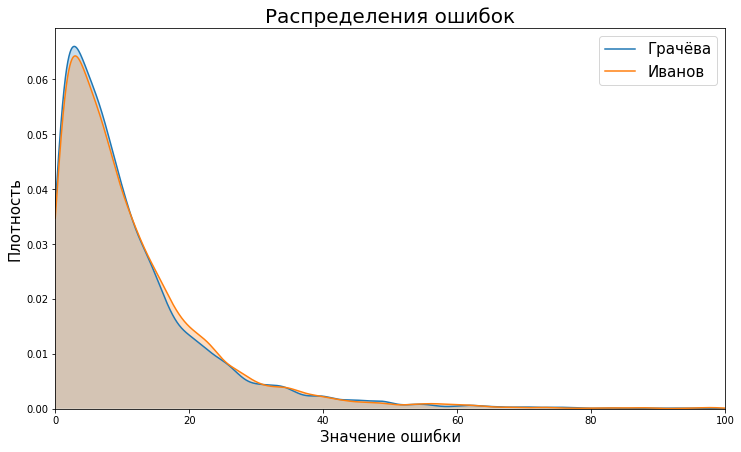

p-value критерия знаков: 0.00021
Разница средних: -0.334
Относительная разница: -3.0%


In [11]:
gracheva_ivanov = make_models_comparison(
    gracheva_errors,
    ivanov_errors,
    label_x='Грачёва',
    label_y='Иванов'
)

**Вывод:**

По графикам видно, что модели участников оказались сильно лучше бейзлайна. Это подтверждают и критерии, pvalue крайне мал, что говорит о высокой уверенности.

При этом оказалось, что и результат двух участников различается значимо. Лучше результат у Насти Грачёвой. Однако здесь pvalue уже не такой мизерный.

Но тем не менее и этого достаточно, чтобы отвергнуть все гипотезы даже после коррекции методом Бонферрони. Оказывается, что критерий знаков позволяет отвергнуть незначимость разницы, когда в метрике MAPE абсолютная разница составила $0.3$, что было на $3$ процента лучше, чем во второй по рейтингу работе.

_________________
### Задача 3

Сессией в интернете называется промежуток времени, охватывающий работу пользователя с момента открытия первой страницы и до закрытия последней. В каждой сессии пользователь может кликнуть на целевой объект. Предположим, базовая конверсия сессии в клик равна 0.08 (т.е. вероятность клика за сессию). С целью проведения AB-тестирования для 5 процентов аудитории выкатывается новый дизайн, от которого ожидается улучшение конверсии на 0.01, т.е. вероятность клика станет равна 0.09. Оцените двумя способами срок такого AB-теста, считая, что все сессии независимы, а на сайте происходит 1000 сессий в день.

__________________________________________

In [2]:
control_conversion = 0.08
test_conversion = 0.09

control_fraction = 0.95
test_fraction = 0.05

events_per_day = 1000

Для того, чтобы определить в данном случае срок AB-теста, воспользуемся двумя предложенными на лекциях методами. А именно посчитаем срок:

* Из соображений мощности
* Из соображений эффекта

Пусть оценки вероятности конверсий оказались в контрольной и тестовой выборке соответственно $p_a$ и $p_b$, количество сессий аналогично $n_a$ и $n_b$

Искомое общее количество сессий обозначим за $n = n_a + n_b$

Долю пользователей, на которых работает тестовая версия, обозначим за $f$

**Из соображений эффекта**

Мы хотим, чтобы произошло отвержение при заданных конверсиях. Для этого надо, чтобы величина, которая, согласно тесту, распределена нормально, была больше $2$.

$$ \frac{p_b - p_a}{\widehat{\sigma}} \geqslant 2 $$

$$ \widehat{\sigma} = \sqrt{\frac{p_b(1 - p_b)}{n_b} + \frac{p_a(1 - p_a)}{n_a}} = \sqrt{\frac{p_b(1 - p_b)}{fn} + \frac{p_a(1 - p_a)}{(1-f)n}} = \frac{1}{\sqrt{n}} \sqrt{\frac{p_b(1 - p_b)}{f} + \frac{p_a(1 - p_a)}{1-f}}  $$

Подставляя выражение для $\widehat{\sigma}$, получаем следующее неравенство:

$$ \sqrt{n} \frac{p_b - p_a}{\sqrt{\frac{p_b(1 - p_b)}{f} + \frac{p_a(1 - p_a)}{1 - f}}} \geqslant 2 $$

Возведя в квадрат, можем получить неравенство на $n$

$$ n \geqslant 4 \frac{\frac{p_b(1 - p_b)}{f} + \frac{p_a(1 - p_a)}{1 - f}}{(p_b - p_a) ^ 2} $$

Остаётся только не забыть про то, что число дней должно быть в $1000$ раз меньше числа сессий, потому что в день на сайте наблюдается $1000$ сессий

In [24]:
def get_effect_ab_length(control_conversion, test_conversion, test_fraction):
    """
    Функция для определения срока АБ-теста из соображений эффекта
    Параметры
    ---------
    control_converion : float
        Текущая конверсия
    test_conversion : float
        Конверсия, на которой должно быть отвержение
    test_fraction : float
        Доля сессий в тестовой выборке
    Возвращает
    ----------
    int : количество дней проведения теста
    """
    
    control_fraction = 1 - test_fraction
    
    test_var = test_conversion * (1 - test_conversion) / test_fraction
    control_var = control_conversion * (1 - control_conversion) / control_fraction
    
    n_sessions =  4 * (test_var + control_var) \
                    / (control_conversion - test_conversion) ** 2
    n_days = int(np.ceil(n_sessions / events_per_day))
    
    return n_days

In [26]:
get_effect_ab_length(control_conversion, test_conversion, test_fraction)

69

Получаем, что необходимо проводить AB-тест в течение $69$ дней

**Из соображений мощности**

Здесь будем действовать проще. При помощи бинарного поиска будем фиксировать количество сессий, семплировать бернуллиевские выборки из контроля и теста, затем на каждой считать критерий Вальда, чтобы оценить мощность.

Мощность нужно считать с точностью хотя бы до 2 знака, поэтому нужно $10000$ семплирований

In [29]:
def wald_test_greater(x, y):
    """
    Критерий Вальда для бернуллиевских выборок
    Альтернатива: mean(y) > mean(x)
    Параметры
    ---------
    x, y : array-like
        Выборки из распределения Бернулли
    Возвращает
    ----------
    float : pvalue критерия
    """
    
    p_x, p_y = x.mean(), y.mean()
    
    var_x = p_x * (1 - p_x)
    var_y = p_y * (1 - p_y)
    
    sigma = np.sqrt(var_x / x.size + var_y / y.size)
    stat = (p_y - p_x) / sigma
    
    return sps.norm.sf(stat)

In [30]:
def get_power_ab_length(
    control_conversion, test_conversion, test_fraction,
    max_sessions=1000000, n_samples=10000, demanded_power=0.8
):
    """
    Функция для определения срока АБ-теста из соображений мощности
    с помощью бинарного поиска
    Параметры
    ---------
    control_converion : float
        Текущая конверсия
    test_conversion : float
        Конверсия, на которой должно быть отвержение
    test_fraction : float
        Доля сессий в тестовой выборке
    max_sessions : int
        Максимально возможное число сессий в эксперименте
    n_samples : int
        Количество семплирований для определения мощности
    demanded_power : float
        Требуемая мощность
    Возвращает
    ----------
    int : количество дней проведения теста
    """
    
    left, right = 1, max_sessions
    while (right - left) > events_per_day:
        # делим пополам, пока различия больше одного дня
        middle = (left + right) / 2
        
        n_rejects = 0
        for _ in range(n_samples):
            n_control = int(middle * control_fraction)
            n_test = int(middle * test_fraction)
            # семплируем из распределения бернулли нужное количество примеров
            control = sps.bernoulli(p=control_conversion).rvs(n_control)
            test = sps.bernoulli(p=test_conversion).rvs(n_test)
            pvalue = wald_test_greater(control, test) # применяем критерий Вальда
            n_rejects += pvalue < 0.05
        power_est = n_rejects / n_samples
        
        print('Число сессий: {:.0f}, оценка мощности: {:.2f}'\
              .format(middle, power_est))
        
        if power_est > demanded_power:
            right = middle
        else:
            left = middle

    return int(np.ceil(middle / events_per_day))

In [33]:
get_power_ab_length(control_conversion, test_conversion, 
                    test_fraction, n_samples=10000)

Число сессий: 500000, оценка мощности: 1.00
Число сессий: 250001, оценка мощности: 0.99
Число сессий: 125001, оценка мощности: 0.86
Число сессий: 62501, оценка мощности: 0.61
Число сессий: 93751, оценка мощности: 0.77
Число сессий: 109376, оценка мощности: 0.82
Число сессий: 101563, оценка мощности: 0.79
Число сессий: 105470, оценка мощности: 0.81
Число сессий: 103517, оценка мощности: 0.80
Число сессий: 102540, оценка мощности: 0.79


103

Получаем, что данный метод даёт большее количество дней, а именно $103$

_______________
### Задача 4

Имеются две задачи:

1. Пусть $X_i = (X_{i1}, ..., X_{id}), i=1,...,n$ -- выборка из $d$-мерных объектов. Для всех пар признаков требуется проверить гипотезу о независимости этих признаков, т.е. $\mathsf{H}_{jk}\colon X_{ij}, X_{ik}$ независимы. Для проверки используется критерий на основе коэффициента корреляции Спирмена. 

2. Пусть решается задача регрессии и $X_i = (X_{i1}, ..., X_{id}), i=1,...,n$ -- выборка из $d$-мерных регрессоров, а $Y_1, ..., Y_n$ -- соответствующие значения отклика. Требуется отобрать значимые признаки, для чего проверяются гипотезы $\mathsf{H}_{j}\colon X_{ij}, Y_{i}$ независимы. Для проверки используется критерий на основе коэффициента корреляции Спирмена. 

В обоих задачах предполагается использовать перестановочный критерий, в котором статистикой является коэффициент корреляции Спирмена.

Задание:
* Предложите группу перестановок для реализации данного критерия, а так же метод генерации бутстрепных выборок. 
* Можно ли в данных задачах использовать метод множественной проверки гипотезы на основе перестановок (maxT-статистика)? Если нет, то нужно привести пример, для которого нарушается какое-либо требование. Если да, то нужно привести пару примеров, для которых свойство выполняется. Примеры можно привести с помощью семплирования.
_____________________

**Группа перестановок**

Нужно предложить такую группу перестановок, которая не меняет распределение коэффициента корреляции Спирмена, поскольку именно на нём основан критерий.

Если гипотеза верна, то есть выборки независимы, при перемешивании элементы внутри каждой выборки, распределение коэффициента корреляции Спирмена не меняется. Аналогичная ситуация для мультигипотез, если все выборки независимы.

Таким образом в качестве группы перестановок для критерия мы берём совокупности перестановок элементов каждой из выборок.

**Применимость maxT**

Рассмотрим на примерах применимость МПГ с помощью перестановок. Чтобы подтвердить её или опровергнуть, проверим распределения корреляции Спирмена.

В качестве модели, из которой генерируются данные, возьмём просто многомерное нормальное распределение. Будем задавать матрицу ковариаций и вектор средних и смотреть на распределения коэффициента корреляции.

Нужно проверить, например, отличается ли совместное распределение коэффициентов корреляции дла некоторых гипотез в зависимости от верности некоторого набора других гипотез.

Напишем функцию, которая генерирует многомерные нормальные данные для матрицы ковариаций в случае верных и неверных гипотез, а потом возвращает набор коэффициентов корреляции для заданных индексов (регрессоров или отклика)

In [35]:
def compare_correlation_distributions(cov_true, cov_false, inds1, inds2,
                                      sample_size=100, n_samples=20000):
    """
    Функция для сравнения коэффициентов корреляции
    в проверке гипотез о независимости выборок
    Параметры
    ---------
    cov_true : 2d array
        Матрица ковариаций распределения при справедливости гипотез
    cov_false : 2d array
        Матрица ковариаций распределения при несправедливости гипотез
    inds1 : Tuple(int, int)
        Пара индексов выборок первой гипотезы из набора
    inds2 : Tuple(int, int)
        Пара индексов выборок второй гипотезы из набора
    sample_size : int
        Размер многомерной выборки
    n_samples : int
        Количество семплированй = размер выборки коэффициентов
    """
    
    cov_true = np.array(cov_true)
    cov_false = np.array(cov_false)
    mean = np.zeros(cov_true.shape[0])
    
    T_true = []
    T_false = []
    
    for _ in tqdm(range(n_samples)):
        #  генерируем многомерную выборку
        sample = sps.multivariate_normal(mean=mean, 
                                         cov=cov_true).rvs(size=sample_size)
        
        # считаем коэффициенты корреляции для нужных регрессоров/отклика
        T_true.append([
            sps.spearmanr(sample[:, inds1[0]], sample[:, inds1[1]])[0],
            sps.spearmanr(sample[:, inds2[0]], sample[:, inds2[1]])[0]
        ])
        
        sample = sps.multivariate_normal(mean=mean, 
                                         cov=cov_false).rvs(size=sample_size)
        
        T_false.append([
            sps.spearmanr(sample[:, inds1[0]], sample[:, inds1[1]])[0],
            sps.spearmanr(sample[:, inds2[0]], sample[:, inds2[1]])[0]
        ])
        
    return T_true, T_false

Также требуется функция, которая изобразит распределения полученных статистик

In [37]:
def show_distributions(T_true, T_false, x_label='Корреляция 1', y_label='Корреляция 2'):
    """
    Функция для построения совместных распределений коэффициентов корреляции
    Параметры
    ---------
    T_true : list
        Список попарных значений коэффициентов при справедливости набора гипотез
    T_false : list
        Список попарных значений коэффициентов при несправедливости набора гипотез
    x_label, y_label : str
        Метки для осей
    """
    
    T_true = np.array(T_true)
    T_false = np.array(T_false)
    plt.figure(figsize=(10, 10))
    plt.title('Сравнение совместных распределений', fontsize=18)
    
    sns.kdeplot(T_true[:, 0], T_true[:, 1], gridsize=100, shade=True,
                shade_lowest=False, alpha=0.5)
    sns.kdeplot(T_false[:, 0], T_false[:, 1], gridsize=100, 
                color='red', shade=True,
                shade_lowest=False, alpha=0.5)
    
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.xlim((-0.3, 0.3))
    plt.ylim((-0.3, 0.3))
    plt.show()

**Пункт 1**

Рассматриваем 3 нормальные выборки. Пусть $T_{jk}$ - статистика для проверки $\mathsf{H}_{jk}$

Покажем, что совместное распределение статистик $T_{12}$ и $T_{13}$ при справедливости $\mathsf{H}_{12}$ и $\mathsf{H}_{13}$ зависит от справедливости $\mathsf{H}_{23}$

Соответственно, рассматриваем матрицы ковариаций, в одной из которых будет зависимость между 2 и 3 признаком, а в другой - не будет

In [47]:
cov_true = [[1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]]

cov_false = [[1, 0, 0],
             [0, 1, 0.5],
             [0, 0.5, 1]]

In [48]:
T_true, T_false = compare_correlation_distributions(
    cov_true, cov_false, (0, 1), (0, 2)
)

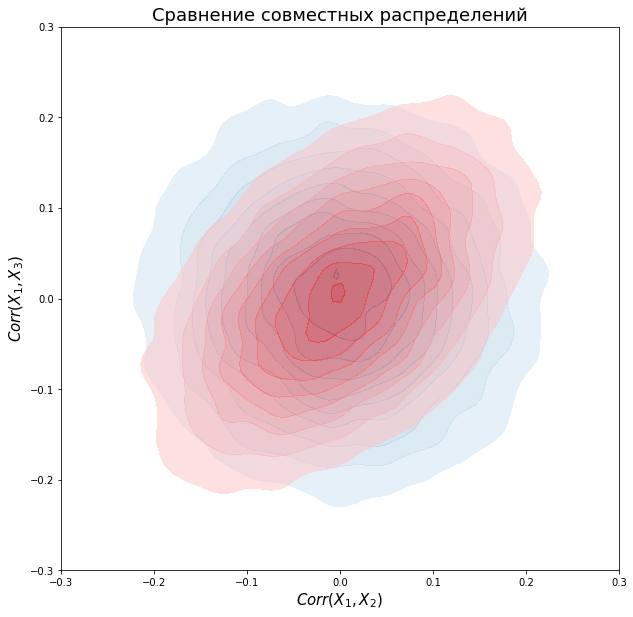

In [49]:
show_distributions(T_true, T_false, x_label="$Corr(X_1, X_2)$", 
                   y_label="$Corr(X_1, X_3)$")

Видим, что распределения отличаются, поэтому сразу видим невозможность использования maxT

**Пункт 2**

Рассматриваем три нормальных выборки регрессоров и одну отклкиков. Пусть $T_{j}$ - статистика для проверки $\mathsf{H}_{j}$. Нужно, например, показать, что совместное распределение статистик $T_{1}$ и $T_{2}$ при справедливости $\mathsf{H}_{1}$ и $\mathsf{H}_{2}$ не зависит от справедливости $\mathsf{H}_{3}$.

В качестве первого примера рассмотрим случай, когда все признаки независимы. А зависимость у третьего признака с откликом либо есть, либо нет.

In [41]:
cov_true = [[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]]

cov_false = [[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 1, 0.9],
             [0, 0, 0.9, 1]]

In [42]:
T_true, T_false = compare_correlation_distributions(
    cov_true, cov_false, (0, 3), (1, 3), 
    n_samples=100000, sample_size=300
)

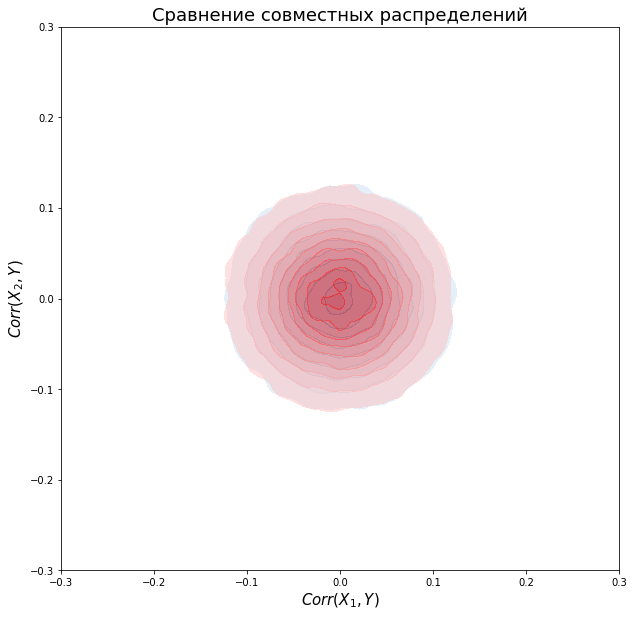

In [44]:
show_distributions(T_true, T_false, x_label="$Сorr(X_1, Y)$", 
                   y_label="$Corr(X_2, Y)$")

По графику можно видеть, что распределения совпадают. Добавим также второй пример, в котором между признаками есть зависимость

In [50]:
cov_true = [[1, 0.3, 0.4, 0],
            [0.3, 1, 0.1, 0],
            [0.4, 0.1, 1, 0],
            [0, 0, 0, 1]]

cov_false = [[1, 0.3, 0.4, 0],
             [0.3, 1, 0.1, 0],
             [0.4, 0.1, 1, 0.9],
             [0, 0, 0.9, 1]]

In [51]:
T_true, T_false = compare_correlation_distributions(
    cov_true, cov_false, (0, 3), (1, 3),
    n_samples=100000, sample_size=300
)

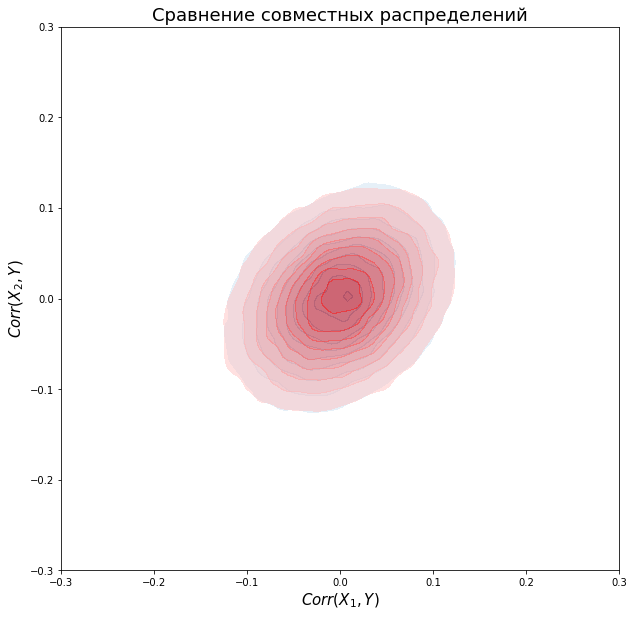

In [52]:
show_distributions(T_true, T_false, x_label="$Сorr(X_1, Y)$", 
                   y_label="$Corr(X_2, Y)$")

Снова видим совпадение распределений

**Вывод:**

Таким образом, в случае с проверкой независимости признаков точно нельзя использовать МПГ на основе перестановок. В случае со значимостью признаков и проверкой независимости с откликом мы получаем, что на рассмотренных примерах совместные распределения совпадают, а значит наверняка применить такую схему возможно.